# Growth Stock Indicator

Please fill out:
* Student name: Joe Wilkinson
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## OSEMN
Obtain - Scrub - Explore - Model - Interpret

We used the OSEMN framework to evaluate our stock market data with the intent of building a model to classify stock prices as growth, contract, or neutral based on where the stock will be one year out. 

## Table of Contents

### [1. Obtain](#1)
1. [Project Discovery](#1.1)
2. [Library and Data Import](#1.2)

### [2. Scrub and Explore](#2)
1. [Subsample](#2.1)
2. [Dealing with Data Types](#2.2)
3. [Dealing with Null Values](#2.3)
4. [Check for Multicollinearity](#2.4)
5. [Normalize Data](#2.5)
6. [Creating visualizations](#2.6)

### [4. Model](#4)
1. [One - Hot - Encoding](#4.1)
2. [Regression](#4.2)
3. [Dimensionality Reduction](#4.3)
4. [Final Model](#4.4)


### [5. Interpret](#5) 

<a id="1"></a>
## Obtain

<a id="1.1"></a>
### New York Stock Exchange data from S&P 500
The dataset we are using to build our model is from Dominik Gawlik and was posted on [Kaggle](https://www.kaggle.com/dgawlik/nyse) with a CCO: Public Domain liscense. Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases. The data is split up into multiple CSV files.

1. **prices.csv:** Raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.

2. **prices-split-adjusted.csv:** Same as prices, but there have been added adjustments for splits.

3. **securities.csv:** General description of each company with division on sectors

4. **fundamentals.csv:** Metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

<a id="1.2"></a>
### Importing Libraries and Data

In [33]:
#imports and loading in data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('ggplot')

The fundamentals CSV is where we'll get most of our predictors from. This file contains data from the financial filings of each company. Filed once a year, so each row will join with 365 days of stock prices.

In [175]:
fundamentals = pd.read_csv('fundamentals.csv', index_col=0)
fundamentals.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [176]:
fundamentals.drop(['Add\'l income/expense items', 'After Tax ROE', 'Capital Expenditures', 'Capital Surplus', 
                   'Cash Ratio', 'Changes in Inventories', 'Common Stocks', 'Cost of Revenue', 'Current Ratio',
                   'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation', 
                   'Earnings Before Interest and Tax', 'Earnings Before Tax', 'Effect of Exchange Rate', 
                   'Equity Earnings/Loss Unconsolidated Subsidiary', 'Goodwill', 'Gross Margin',
                   'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense', 'Minority Interest', 
                   'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating', 
                   'Net Cash Flows-Financing', 'Net Cash Flows-Investing',
                   'Net Income Adjustments', 'Net Income Applicable to Common Shareholders', 
                   'Net Income-Cont. Operations', 'Net Receivables', 'Non-Recurring Items', 'Operating Margin', 
                   'Other Assets', 'Other Equity', 'Other Financing Activities', 'Other Investing Activities', 
                   'Other Liabilities', 'Other Operating Activities', 'Other Operating Items', 'Pre-Tax Margin', 
                   'Pre-Tax ROE', 'Profit Margin', 'Quick Ratio', 'Retained Earnings',
                   'Sale and Purchase of Stock', 'Sales, General and Admin.', 'Treasury Stock', 'For Year',
                   'Estimated Shares Outstanding'],
                  axis = 1, inplace = True)
fundamentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 1780
Data columns (total 26 columns):
Ticker Symbol                                          1781 non-null object
Period Ending                                          1781 non-null object
Accounts Payable                                       1781 non-null float64
Accounts Receivable                                    1781 non-null float64
Cash and Cash Equivalents                              1781 non-null float64
Fixed Assets                                           1781 non-null float64
Inventory                                              1781 non-null float64
Investments                                            1781 non-null float64
Liabilities                                            1781 non-null float64
Long-Term Debt                                         1781 non-null float64
Long-Term Investments                                  1781 non-null float64
Net Income                                      

For stock prices, we'll use the adjusted for split prices so that stock splits won't affect the outcomes of our classification.

In [177]:
adj_price = pd.read_csv('prices-split-adjusted.csv')
adj_price.drop(['open', 'high', 'low', 'volume'], axis = 1, inplace = True)
adj_price.head()
# adj_price.info()

,date,symbol,close
0,2016-01-05,WLTW,125.839996
1,2016-01-06,WLTW,119.980003
2,2016-01-07,WLTW,114.949997
3,2016-01-08,WLTW,116.620003
4,2016-01-11,WLTW,114.970001


In [178]:
securities = pd.read_csv('securities.csv')
securities.drop(['Security', 'SEC filings', 'GICS Sub Industry', 'Address of Headquarters', 
                 'Date first added', 'CIK'], axis = 1, inplace = True)
securities.head()

,Ticker symbol,GICS Sector
0,MMM,Industrials
1,ABT,Health Care
2,ABBV,Health Care
3,ACN,Information Technology
4,ATVI,Information Technology


Now that we have all the data, we have to combine it into one dataframe. Before we do that, we drop all the columns that we won't use.
- fundamentals: [Unnamed: 0]
- price: [open, low, high]
- Securities: [SEC filings, Date first added, CIK]

Then we'll add the `securities` details to each of the observations in `adj_price`, merging on the `stock symbol`. From there we can add columns for year to both our new master df and fundamentals. This will allow us to to merge the fundamental details to all price observations in that year. 

After we have one combined dataframe, we need to add a column for `pct_growth` that tells us how much the stock has grown or contracted one year from the date.

In [179]:
df = adj_price.merge(securities, how='left', left_on='symbol', right_on='Ticker symbol')
df.drop(['Ticker symbol'], axis=1, inplace=True)

# Make date columns datetime
df['date'] = pd.to_datetime(df['date'])
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])

# Create a new column for year
df['year'] = [d.year for d in df['date']]
df['month'] = [d.month for d in df['date']]
df['day'] = [d.day for d in df['date']]
# Plus one because we want to use 2012's EOY financials with 2013's prices
fundamentals['year'] = [pe.year + 1 for pe in fundamentals['Period Ending']]

# Merge on year
df = df.merge(fundamentals, how='inner', left_on=['symbol', 'year'], right_on=['Ticker Symbol', 'year'])
df.drop(['Ticker Symbol', 'Period Ending'], axis=1, inplace=True)


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 31 columns):
date                                                   388642 non-null datetime64[ns]
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null object
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory            

In [181]:
def get_future_price(row):
    date = row.date + relativedelta(years=1)
    price = None
    symbol = row.symbol
    cnt = 0
    while price == None and cnt < 7:
        try:
            price = float(df.loc[(df['date'] == date) & (df['symbol'] == symbol)].close)
            continue
        except:
            price = None
        date = date + relativedelta(days=1)
        cnt +=1
    return price



Our end of year financials are most relevant in the first month of the following year. The further into the next year that we get, the more the company has changed and the more outdated that information is. So, we'll just take the data from January of each year and drop any 2016 observations all together because they can't have a future date in our dataset.

In [182]:
# Get january future close price
# data = df.loc[df['month'] == 1]

# data['future_close'] = data.apply(lambda row: get_future_price(row), axis=1) #36 minutes to execute

# Get full dataset future close price
df['future_close'] = df.apply(lambda row: get_future_price(row), axis=1) # Estimated 6 hrs to execute

data.future_close.isna().sum()

AttributeError: 'DataFrame' object has no attribute 'future_close'

In [183]:
df.future_close.isna().sum()

115313

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31041 entries, 0 to 388408
Data columns (total 32 columns):
date                                                   31041 non-null datetime64[ns]
symbol                                                 31041 non-null object
close                                                  31041 non-null float64
GICS Sector                                            31041 non-null object
year                                                   31041 non-null int64
month                                                  31041 non-null int64
day                                                    31041 non-null int64
Accounts Payable                                       31041 non-null float64
Accounts Receivable                                    31041 non-null float64
Cash and Cash Equivalents                              31041 non-null float64
Fixed Assets                                           31041 non-null float64
Inventory                        

In [184]:
# Save dataset to csv so we don't have to rerun the last bit of code
# data.to_csv('january_data.csv')
df.to_csv('full_data.csv')
# data.drop(['Unnamed: 0'], axis=1, inplace=True)

<a id="2"></a>
## Scrub
<a id="2.1"></a>
### 1. Subsample
We took a subsample of the data to imporove run times and stored it in the variable 'df'. 

*To see the final results, comment out.*

In [77]:
# df = pd.read_csv('january_data.csv', index_col=0)
df = pd.read_csv('full_data.csv', index_col=0)
# df = df.sample(frac=0.2, random_state=5)


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 32 columns):
date                                                   388642 non-null object
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null object
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory                    

<a id="2.2"></a>
### 2. Dealing with Datatypes 
When looking at the data we can see there are only two categorical data columns. We'll need to make sure that we are only adding variables that will add a lot of value without needlessly growing complexity.

- `GICS Sector`: There aren't too many different sectors, so we'll keep thiss column and convert to categorical data type
- `Symbol`: We'll drop this column as they are arbitrary stock names



In [79]:
df['GICS Sector'] = df['GICS Sector'].astype('category')
# df.drop(['symbol'], axis = 1, inplace = True)

In [80]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = [d.year for d in df['date']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388642 entries, 0 to 388641
Data columns (total 32 columns):
date                                                   388642 non-null object
symbol                                                 388642 non-null object
close                                                  388642 non-null float64
GICS Sector                                            388642 non-null category
year                                                   388642 non-null int64
month                                                  388642 non-null int64
day                                                    388642 non-null int64
Accounts Payable                                       388642 non-null float64
Accounts Receivable                                    388642 non-null float64
Cash and Cash Equivalents                              388642 non-null float64
Fixed Assets                                           388642 non-null float64
Inventory                  

<a id="2.3"></a>
### 3. Dealing with Null Values
We'll drop the `Cash Ratio`, `Current Ratio`, and `Quick Ratio` columns because the information here is just a calculation based on other columns, so there's no new information.

We chose to drop all rows that had null values in the `For Year`, `Earnings Per Share`, `Estimated Shares Outstanding`, `future_close` columns. There was a low number of rows that were missing data.

In [81]:

print(df.year.unique()) # outputs: [2016 2013 2014 2015]
print(len(df)) # 31041 entries

df = df.loc[df['year'] != 2016]
print(df.year.unique()) # outputs: [2013 2014 2015]
print(len(df)) #  22606 entries



[2016 2013 2014 2015]
388642
[2013 2014 2015]
276755


In [82]:
# Drop null values
df.dropna(inplace=True)

In [83]:
# Additionally, we'll drop year and day as they should have no effect on the outcome
df.drop(['day'], axis=1, inplace=True)
# data.info()

** Maybe **
Next we'll group each stocks observations by month and year and averaging the price and future_price. This will help us eliminate some of the volitility from any individual day's data.

The next step is to calculate our dependent variable by calculating the percentage change from the current price to the future price.

In [84]:
def growth_category(row):
    p1 = row.close
    p2 = row.future_close
    result = (p2 - p1)/(p1)
    if result >= .1:
        return 2
    elif result >= 0:
        return 1
    else:
        return 0

In [85]:
df['growth_category'] = df.apply(lambda row: growth_category(row), axis=1)

In [86]:
print(len(df.growth_category))
df.growth_category.value_counts()

258676


2    120131
0     89125
1     49420
Name: growth_category, dtype: int64

At this point we can drop the `future_close` column since we were only using it to calculate the growth_category, as well as `symbol` and `date`.

In [87]:
df['sector'] = df['GICS Sector']
df.head()

,date,symbol,close,GICS Sector,year,month,Accounts Payable,Accounts Receivable,Cash and Cash Equivalents,Fixed Assets,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Earnings Per Share,future_close,growth_category,sector
251,2013-01-02,AAL,13.98,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,25.360001,2,Industrials
252,2013-01-03,AAL,13.66,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,26.540001,2,Industrials
253,2013-01-04,AAL,14.73,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,27.030001,2,Industrials
254,2013-01-07,AAL,14.84,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,26.910000,2,Industrials
255,2013-01-08,AAL,15.16,Industrials,2013,1,3.068000e+09,-222000000.0,1.330000e+09,1.340200e+10,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-5.6,27.629999,2,Industrials


In [88]:
# data.drop(['future_close'], axis=1, inplace=True)
df.index = df.date
# df['sector'] = df['GICS Sector']
df = df.groupby(by=[df.symbol, df.month, df.year], as_index=False).mean()
# df.info()
# data.drop(['symbol', 'date'], axis=1, inplace=True)
df.drop(['future_close'], axis=1, inplace=True)

In [89]:
# df.drop(['date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 28 columns):
close                                                  12344 non-null float64
year                                                   12344 non-null float64
month                                                  12344 non-null float64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments            

In [92]:
df['sector'].head()

KeyError: 'sector'

We want our model to be agnostic of the year since we're not doing time series analysis of our data. This means we can drop the year. We'll also drop close because we're only trying to predict percentage growth based on financial statements.

In [16]:

df.drop(['close', 'year'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 26 columns):
month                                                  12344 non-null float64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments                                  12344 non-null float64
Net Income                                             12344 non-null float64
Operating Income                 

In [17]:
# df.to_csv('average_by_month_january.csv')
df.to_csv('average_by_month.csv')

--- Checkpoint ---

In [34]:
# data = pd.read_csv('average_by_month_january.csv', index_col=0)
data = pd.read_csv('average_by_month.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12344 entries, 0 to 12343
Data columns (total 26 columns):
month                                                  12344 non-null float64
Accounts Payable                                       12344 non-null float64
Accounts Receivable                                    12344 non-null float64
Cash and Cash Equivalents                              12344 non-null float64
Fixed Assets                                           12344 non-null float64
Inventory                                              12344 non-null float64
Investments                                            12344 non-null float64
Liabilities                                            12344 non-null float64
Long-Term Debt                                         12344 non-null float64
Long-Term Investments                                  12344 non-null float64
Net Income                                             12344 non-null float64
Operating Income                 

In [35]:
# Get our independent and dependent variables
y = df['growth_category'].astype('int')
X = df.drop(['growth_category'], axis = 1)

<a id="2.5"></a>
### 5. Normalize Data
Our next step it to standardize all the data. We don't want certain features to have too strong of an influence just because the nature of that particular feature, the numbers are higher. For example, Earnings per share is generally a low number because it's Revenue divided by the number of shares outstanding, while Our total Assets number is going to be astronomical compared to EPS. We don't want Assets to simply out rank EPS. EPS could potentially be more important, so by standardizing all features, we can even the playing field.

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [37]:
y.head()

0    2
1    2
2    0
3    2
4    2
Name: growth_category, dtype: int64

<a id="4"></a>
## 4. Model

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

### K Neighbors Classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[988 155 171]
 [277 229 191]
 [349 207 519]]
Accuracy:  0.5625405055087492


### Support Vector Machine

In [41]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', random_state = 3)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=3,
    shrinking=True, tol=0.001, verbose=False)

In [42]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1301    0   13]
 [ 689    0    8]
 [1046    0   29]]
Accuracy:  0.4309786130913804


### Kernel SVM

In [43]:
clf = SVC(kernel = 'rbf', random_state = 3)
clf.fit(X_train, y_train)

/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=3,
    shrinking=True, tol=0.001, verbose=False)

In [44]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[912   5 397]
 [384  22 291]
 [493  15 567]]
Accuracy:  0.48639014906027217


### Decision Tree

In [104]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 3)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=3, splitter='best')

In [105]:
y_pred = clf_dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1096  176   42]
 [ 161  361  175]
 [  42  199  834]]
Accuracy:  0.7423849643551523


### Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 3)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [107]:
y_pred = clf_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print('Accuracy: ', acc)

[[1149  151   14]
 [ 156  375  166]
 [  18  191  866]]
Accuracy:  0.7744653272845107


### Validation
Here are the accuracy results from our initial models. 

| Model         | Accuracy |
|---------------|----------|
| K Neighbors   | 0.5625   |
| SVM           | 0.4310   |
| Kernel SVM    | 0.4864   |
| Decision Tree | 0.7424   |
| Random Forest | 0.7745   |

There are two models that are clearly better than the rest, Decision Tree and Random Forest. Next we'll use K-Fold Cross Validation to get a more reliable picture of which model is stronger by eliminating the chance that random sampling caused the difference in outcomes.

In [109]:
from sklearn.model_selection import cross_val_score
accuracies_dt = cross_val_score(clf_dt, X = X_train, y = y_train, cv = 10)
print('Decision Tree Results:')
print('Accuracies Mean: ', accuracies_dt.mean())
print('Accuracies Standard Deviation: ', accuracies_dt.std())
accuracies_rf = cross_val_score(clf_rf, X = X_train, y = y_train, cv = 10)
print('Random Forest Results:')
print('Accuracies Mean: ', accuracies_rf.mean())
print('Accuracies Standard Deviation: ', accuracies_rf.std())

Decision Tree Results:
Accuracies Mean:  0.7169982214186328
Accuracies Standard Deviation:  0.010332084038613394
Random Forest Results:
Accuracies Mean:  0.7511322703999421
Accuracies Standard Deviation:  0.011035581112188473


With a standard deviation of around 0.01 for both models, we know they are both very consistent and the difference of ~4% is unlikely to be caused by sampling errors. So, we can confidently select the `Random Forest` as our classifying model.

Our next steps are to imporove our results feature selection. We want to determine which features are giving us more predictive power and remove ones that may just be noise.

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit(X_test)

print(pca.explained_variance_ratio_)

[3.70626447e-01 2.21694717e-01 7.06662345e-02 4.83241220e-02
 4.79182007e-02 4.28866059e-02 3.79230901e-02 3.60025238e-02
 3.18690963e-02 2.75941795e-02 1.82162051e-02 1.06209892e-02
 9.19563799e-03 6.95198863e-03 5.25632676e-03 3.74340609e-03
 3.05800964e-03 3.00209510e-03 1.72310878e-03 1.22296744e-03
 1.07003598e-03 3.53197911e-04 8.07704046e-05 4.37768774e-08
 4.24313511e-33]


In [118]:
np.sum([3.70626447e-01, 2.21694717e-01, 7.06662345e-02, 4.83241220e-02,
 4.79182007e-02, 4.28866059e-02, 3.79230901e-02, 3.60025238e-02,
 3.18690963e-02, 2.75941795e-02, 1.82162051e-02])

0.9537214219

In [138]:
def get_pca_results(clf, X_train, X_test, y_train, y_test, components=None):
    """This function returns the accuracy score of a given model.
    * Uses 10 fold cross validation to reduce sampling errors
    
    Keyword arguments:
    clf        -- classifier to use
    X_train    -- training set of features
    X_test     -- test set of features
    y_train    -- training set of outcomes
    y_test     -- test set of outcomes
    components -- the number of components to get out of PCA (default None)
    """
    pca = PCA(n_components = components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    accuracies = cross_val_score(clf, X = X_train_reduced, y = y_train, cv = 10)
    return accuracies.mean()

In [144]:
clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 3)
for i in range(1, len(X[0]) + 1):
    print(i, ': ', get_pca_results(clf, X_train, X_test, y_train, y_test, i))

1 :  0.40429821726936366
2 :  0.6542508806291648
3 :  0.7318030889707379
4 :  0.7365538963949919
5 :  0.7442215177501301
6 :  0.7253242999898833
7 :  0.7260733627608168
8 :  0.7307196736887861
9 :  0.7355757875374769
10 :  0.7435718193888002
11 :  0.7424873566545651
12 :  0.7413035307938536
13 :  0.745842559676232
14 :  0.746163964548854
15 :  0.7464865341306659
16 :  0.7500531760449142
17 :  0.7496191083889086
18 :  0.7475673872681359
19 :  0.7462682220080782
20 :  0.7497310669030143
21 :  0.747679229535318
22 :  0.7476772458359406
23 :  0.7519985354822529
24 :  0.7507026426868528
25 :  0.7492978162245919




Even though our accuracy did not increase much, it did increase even though we reduced the number of features almost in half.

TypeError: float() argument must be a string or a number, not 'PCA'

<a id="4.1"></a>
### 1. One Hot Encode and Standardize
To be able to run numerical calculations on categorical columns, we have to one-hot-encode them. This turns each unique value into it's own column of 1's and 0's. 

In [199]:
# Create one-hot-encoded data for categorical columns
data['GICS Sector'] = pd.Categorical(data['GICS Sector'])
sector = pd.get_dummies(data['GICS Sector'], prefix='sector')
X.drop(['GICS Sector'], axis=1, inplace=True)
column_names = X.columns
# Standardize numerical columns
sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns=column_names)
# Concat standardized columns with one-hot-encoded columns
X = pd.concat([X, sector], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22412 entries, 0 to 22551
Data columns (total 87 columns):
close                                                  21142 non-null float64
volume                                                 21142 non-null float64
month                                                  21142 non-null float64
Accounts Payable                                       21142 non-null float64
Accounts Receivable                                    21142 non-null float64
Add'l income/expense items                             21142 non-null float64
After Tax ROE                                          21142 non-null float64
Capital Expenditures                                   21142 non-null float64
Capital Surplus                                        21142 non-null float64
Cash and Cash Equivalents                              21142 non-null float64
Changes in Inventories                                 21142 non-null float64
Common Stocks                    

In [217]:
# X.iloc[:, 70:-1]
X['sector_Consumer Discretionary'].value_counts()

0.0    18078
1.0     3064
Name: sector_Consumer Discretionary, dtype: int64

<a id="4.2"></a>
### 2. Regression
To build the most predictive model that we can, we'll look at a few diffent transformations and how that effects the predicitability of the model. First we'll start with our scrubbed and cleaned data with an unaltered `price` dependent variable.

In [63]:
ind_vars.view = ind_vars.view.astype('uint8')
X = ind_vars
y = dep_var
y_log = np.log(y)
X = sm.add_constant(X)

# fit a linear model for our data
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     672.5
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:41:22   Log-Likelihood:            -2.5410e+05
No. Observations:               18749   AIC:                         5.084e+05
Df Residuals:                   18665   BIC:                         5.090e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.35e+05   1735.640    308.246      0.000    5.32e+05    5.38e+05
date          -1.245e+04   1368.495     -9.100      0.000   -1.51e+04   -9770.524
bedrooms       -3.27e+04   1853.937    -17.638      0.000   -3.63e+04   -2.91e+04
bathrooms      6808.7678   2460.211      2.768      0.006    1986.531    1.16e+04
sqft_lot       3.751e+04   2096.446     17.894      0.000    3.34e+04    4.16e+04
floors        -2939.8610   2258.915     -1.301      0.193   -7367.540    1487.818
waterfront     7.036e+04   1444.119     48.722      0.000    6.75e+04    7.32e+04
view            1.34e+05   5339.745     25.095      0.000    1.24e+05    1.44e+05
condition      1.402e+04   1528.522      9.172      0.000     1.1e+04     1.7e+04
sqft_above     1.842e+05   3006.787     61.246      0.000    1.78e+05     1.9e+05
sqft_basement  7.136e+04   1896.196     37.632      0.000    6.76e+04    7.51e+04
yr_built       4968.2930   2195.131      2.263      0.024     665.636    9270.950
lat            3.833e+04   1.09e+04      3.502      0.000    1.69e+04    5.98e+04
long          -2.435e+04   8051.239     -3.024      0.002   -4.01e+04   -8568.498
sqft_living15  2.057e+04   2316.432      8.879      0.000     1.6e+04    2.51e+04
98001         -1.795e+05   2.24e+04     -8.001      0.000   -2.24e+05   -1.36e+05
98002         -1.277e+05   2.38e+04     -5.365      0.000   -1.74e+05    -8.1e+04
98003         -1.813e+05   2.32e+04     -7.816      0.000   -2.27e+05   -1.36e+05
98004          6.208e+05   1.23e+04     50.498      0.000    5.97e+05    6.45e+05
98005          1.079e+05   1.58e+04      6.820      0.000    7.69e+04    1.39e+05
98006          1.231e+05   9941.679     12.381      0.000    1.04e+05    1.43e+05
98007          5.009e+04   1.81e+04      2.774      0.006    1.47e+04    8.55e+04
98008          5.522e+04   1.39e+04      3.960      0.000    2.79e+04    8.25e+04
98010         -8.552e+04   2.85e+04     -2.997      0.003   -1.41e+05   -2.96e+04
98011         -1.548e+05   2.13e+04     -7.268      0.000   -1.97e+05   -1.13e+05
98014         -1.354e+05   2.91e+04     -4.647      0.000   -1.93e+05   -7.83e+04
98019         -1.832e+05   2.56e+04     -7.169      0.000   -2.33e+05   -1.33e+05
98022         -1.249e+05   3.16e+04     -3.956      0.000   -1.87e+05    -6.3e+04
98023         -2.003e+05   2.36e+04     -8.487      0.000   -2.47e+05   -1.54e+05
98024         -4.446e+04   2.78e+04     -1.598      0.110    -9.9e+04    1.01e+04
98027         -6958.7995   1.39e+04     -0.500      0.617   -3.42e+04    2.03e+04
98028         -1.653e+05   1.98e+04     -8.366      0.000   -2.04e+05   -1.27e+05
98029          5.527e+04   1.63e+04      3.391      0.001    2.33e+04    8.72e+04
98030         -1.777e+05    1.9e+04     -9.345      0.000   -2.15e+05    -1.4e+05
98031         -1.681e+05   1.69e+04     -9.940   

With the unaltered `price`, we get a R-squared of *0.749* and an adjusted R-squared of *0.748*. This a moderately predictive model but let's see if we can do better by using the logged version of `price`.

In [64]:
# fit a linear model for our data with a log transformed dependent variable
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1514.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:41:23   Log-Likelihood:                 4570.4
No. Observations:               18749   AIC:                            -8973.
Df Residuals:                   18665   BIC:                            -8314.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8544      0.002   7266.194      0.000      12.851      12.858
date             -0.0230      0.001    -16.499      0.000      -0.026      -0.020
bedrooms         -0.0214      0.002    -11.349      0.000      -0.025      -0.018
bathrooms         0.0364      0.003     14.525      0.000       0.032       0.041
sqft_lot          0.0617      0.002     28.857      0.000       0.057       0.066
floors           -0.0056      0.002     -2.441      0.015      -0.010      -0.001
waterfront        0.0511      0.001     34.722      0.000       0.048       0.054
view              0.1474      0.005     27.075      0.000       0.137       0.158
condition         0.0346      0.002     22.201      0.000       0.032       0.038
sqft_above        0.2263      0.003     73.825      0.000       0.220       0.232
sqft_basement     0.0709      0.002     36.691      0.000       0.067       0.075
yr_built          0.0184      0.002      8.202      0.000       0.014       0.023
lat               0.0815      0.011      7.307      0.000       0.060       0.103
long             -0.0613      0.008     -7.473      0.000      -0.077      -0.045
sqft_living15     0.0724      0.002     30.651      0.000       0.068       0.077
98001            -0.2284      0.023     -9.984      0.000      -0.273      -0.184
98002            -0.2043      0.024     -8.423      0.000      -0.252      -0.157
98003            -0.2103      0.024     -8.898      0.000      -0.257      -0.164
98004             0.8172      0.013     65.221      0.000       0.793       0.842
98005             0.4206      0.016     26.071      0.000       0.389       0.452
98006             0.3982      0.010     39.294      0.000       0.378       0.418
98007             0.3608      0.018     19.603      0.000       0.325       0.397
98008             0.3573      0.014     25.143      0.000       0.329       0.385
98010             0.0992      0.029      3.410      0.001       0.042       0.156
98011            -0.0003      0.022     -0.013      0.990      -0.043       0.042
98014             0.0220      0.030      0.739      0.460      -0.036       0.080
98019            -0.0463      0.026     -1.779      0.075      -0.097       0.005
98022            -0.0137      0.032     -0.425      0.671      -0.077       0.049
98023            -0.2639      0.024    -10.968      0.000      -0.311      -0.217
98024             0.1954      0.028      6.891      0.000       0.140       0.251
98027             0.2833      0.014     19.983      0.000       0.256       0.311
98028            -0.0467      0.020     -2.317      0.020      -0.086      -0.007
98029             0.4020      0.017     24.191      0.000       0.369       0.435
98030            -0.1802      0.019     -9.298      0.000      -0.218      -0.142
98031            -0.1657      0.017     -9.616   

| Dep Var     | price | log_price |
|-------------|-------|-----------|
| R-sq        | 0.749 | 0.871     |
| Adj. R-sq   | 0.748 | 0.870     |
| F-statistic | 672.5 | 1514      |

It looks like our log transformed dependent variable allows us to have much more predictive power in our model, so we'll stick with that moving forward. 

At this point, we'll also drop any continuous variables that have a r-sq < 0.01 because those variables add so little that they are negligible and are over complicating our model. Finally, we'll drop one column of each categorical variable. This will help us avoid redundancy.

In [65]:
data = X.join(y_log)
for var in ind_vars.select_dtypes(include=['int64', 'float64']):
    formula = 'price~' + str(var)
    print(formula)
    model = smf.ols(formula=formula, data=data)
    reg = model.fit()
    print('r-sq: ', reg.rsquared)
    # Drop variables with r-squared < 0.01
    if reg.rsquared < 0.01:
        X.drop(var, axis=1, inplace=True)
        print('dropped')
    print('-------------------------')

X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)

price~date
r-sq:  3.04924900885e-08
dropped
-------------------------
price~bedrooms
r-sq:  0.117811795022
-------------------------
price~bathrooms
r-sq:  0.270239548221
-------------------------
price~sqft_lot
r-sq:  0.0190727824117
-------------------------
price~floors
r-sq:  0.106383488337
-------------------------
price~waterfront
r-sq:  0.0319152714983
-------------------------
price~condition
r-sq:  0.00171072944244
dropped
-------------------------
price~sqft_above
r-sq:  0.346021427625
-------------------------
price~sqft_basement
r-sq:  0.0985711183603
-------------------------
price~yr_built
r-sq:  0.00684577956569
dropped
-------------------------
price~lat
r-sq:  0.203959025551
-------------------------
price~long
r-sq:  0.00276017423884
dropped
-------------------------
price~sqft_living15
r-sq:  0.366168703402
-------------------------


In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18749 entries, 1 to 21596
Data columns (total 80 columns):
const            18749 non-null float64
bedrooms         18749 non-null float64
bathrooms        18749 non-null float64
sqft_lot         18749 non-null float64
floors           18749 non-null float64
waterfront       18749 non-null float64
view             18749 non-null uint8
sqft_above       18749 non-null float64
sqft_basement    18749 non-null float64
lat              18749 non-null float64
sqft_living15    18749 non-null float64
98001            18749 non-null uint8
98002            18749 non-null uint8
98003            18749 non-null uint8
98004            18749 non-null uint8
98005            18749 non-null uint8
98006            18749 non-null uint8
98007            18749 non-null uint8
98008            18749 non-null uint8
98010            18749 non-null uint8
98011            18749 non-null uint8
98014            18749 non-null uint8
98019            18749 non-null uin

In [67]:
# refit model
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1517.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:41:23   Log-Likelihood:                 4182.2
No. Observations:               18749   AIC:                            -8204.
Df Residuals:                   18669   BIC:                            -7577.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4343      0.014    963.730      0.000      13.407      13.462
bedrooms         -0.0202      0.002    -10.564      0.000      -0.024      -0.016
bathrooms         0.0419      0.002     17.471      0.000       0.037       0.047
sqft_lot          0.0573      0.002     27.322      0.000       0.053       0.061
floors           -0.0087      0.002     -3.808      0.000      -0.013      -0.004
waterfront        0.0512      0.002     34.134      0.000       0.048       0.054
view              0.1491      0.006     26.889      0.000       0.138       0.160
sqft_above        0.2264      0.003     72.367      0.000       0.220       0.233
sqft_basement     0.0730      0.002     37.099      0.000       0.069       0.077
lat               0.0823      0.011      7.247      0.000       0.060       0.105
sqft_living15     0.0699      0.002     29.128      0.000       0.065       0.075
98001            -0.7778      0.032    -24.222      0.000      -0.841      -0.715
98002            -0.7659      0.034    -22.835      0.000      -0.832      -0.700
98003            -0.7424      0.032    -23.108      0.000      -0.805      -0.679
98004             0.2366      0.017     13.964      0.000       0.203       0.270
98005            -0.1652      0.020     -8.275      0.000      -0.204      -0.126
98006            -0.1949      0.017    -11.512      0.000      -0.228      -0.162
98007            -0.2414      0.022    -11.128      0.000      -0.284      -0.199
98008            -0.2562      0.017    -14.762      0.000      -0.290      -0.222
98010            -0.5525      0.035    -15.593      0.000      -0.622      -0.483
98011            -0.5886      0.021    -28.036      0.000      -0.630      -0.547
98014            -0.7148      0.023    -31.381      0.000      -0.759      -0.670
98019            -0.7400      0.021    -35.605      0.000      -0.781      -0.699
98022            -0.6637      0.040    -16.573      0.000      -0.742      -0.585
98023            -0.7716      0.032    -24.369      0.000      -0.834      -0.709
98024            -0.5121      0.027    -18.790      0.000      -0.566      -0.459
98027            -0.3640      0.019    -19.251      0.000      -0.401      -0.327
98028            -0.6154      0.019    -31.955      0.000      -0.653      -0.578
98029            -0.2701      0.018    -14.878      0.000      -0.306      -0.235
98030            -0.7629      0.029    -26.505      0.000      -0.819      -0.706
98031            -0.7426      0.027    -28.006      0.000      -0.795      -0.691
98032            -0.7913      0.031    -25.261      0.000      -0.853      -0.730
98033            -0.1604      0.016    -10.117      0.000      -0.192      -0.129
98034            -0.4398      0.016    -27.423      0.000      -0.471      -0.408
98038            -0.6573      0.027    -24.226   

| Dep Var     | price | log_price | w/ removed vars |
|-------------|-------|-----------|-----------------|
| R-sq        | 0.753 | 0.872     | 0.866           |
| Adj. R-sq   | 0.752 | 0.871     | 0.866           |
| F-statistic | 685.7 | 1526      | 1529           |

In [68]:
# Reformat our y_log variable to be a pandas series
y = pd.DataFrame(y_log)
y.shape

(18749, 1)

<a id="4.3"></a>
### 3. Dimensionality Reduction
*Find the best fit*

Loop through all possible number of features to include and fit a regression model to it. Then use K-Fold Cross Validation to insure no overfitting. Because the zip code categories comprise of the majority of features we're using in the model, this might cause overfitting. We don't want to drop the zipcodes unless it effects the strength of our statistical analysis because location is known to have such a large impact on property values. So, we'll check our results on a couple of different measures. 

First, we will calculate the R Squared score for each trial in our k-fold cross validation. This gives us an idea of how well our model at that specific number of featurs fits the data. 1 is the best possible score. 

Second, we will calculate the standard deviation of the R Squared scores for each trial. This lets us know the variability of the data. Knowing the variability allows us to just save the mean of the r squares for each cross fold validation and it lets us know if the results of our cross fold validation is consistant and therefore more predictive.

To add an extra layer of protection, we'll run all of these steps for different levels of k. This will let us know if our results are from sampling bias or are just predictive on it's own. 

Finally, we store the # of features that best predicts our dependent variable and fit a regression line to it.

In [69]:
# find the best fit by looping through all possible number of features and storing the best predicting one
linreg = LinearRegression()

def multiple_cross_validations(columns):
    results = [['folds', 'features', 'score', 'stdev']]
    best_fit = [0, 0, -1]
    for fold in range(10, 101, 10):
        for i in range(1, len(columns)):
            observation = []
            observation.append(fold)
            observation.append(i)
            # Using i features, fit a model
            selector = RFE(linreg, n_features_to_select=i)
            selector = selector.fit(X, np.ravel(y_log))
            selected_columns = X.columns[selector.support_]

            # Cross Validation to ensure no overfitting
            cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=fold, scoring="r2")
            observation.append(np.mean(cv_10))
            observation.append(np.std(cv_10))
            # If the fit is better than the stored `best_fit`, replace it
            if (np.mean(cv_10)) > (best_fit[2]):
                best_fit[1] = i
                best_fit[2] = np.mean(cv_10) 
#             # Print data for each iteration
#             print("""{}: {}, {}: {}, {}: {}, {}: {}""".format(results[0][0], observation[0], 
#                          results[0][1], observation[1],
#                          results[0][2], round(observation[2], 4),
#                          results[0][3], round(observation[3], 4)))        
            results.append(observation)
    return results, best_fit

        
data, best = multiple_cross_validations(X.columns)
cross_results = pd.DataFrame(data=data, columns=data[0])
cross_results.drop([0], inplace=True)
cross_results.head(12)
print(best)


[0, 79, 0.86285769619843788]


In [70]:
cross_results = pd.DataFrame(data=data, columns=data[0])
cross_results.drop([0], inplace=True)
cross_results.head(3)
cross_results.folds = cross_results.folds.astype(int)
cross_results.features = cross_results.features.astype(int)
cross_results.score = cross_results.score.astype(float)
cross_results.stdev = cross_results.stdev.astype(float)
cross_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 1 to 790
Data columns (total 4 columns):
folds       790 non-null int64
features    790 non-null int64
score       790 non-null float64
stdev       790 non-null float64
dtypes: float64(2), int64(2)
memory usage: 30.9 KB


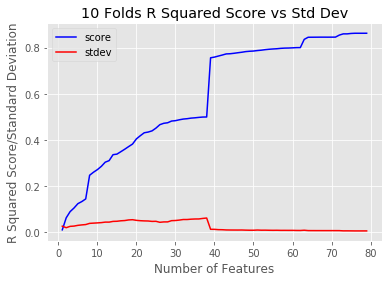

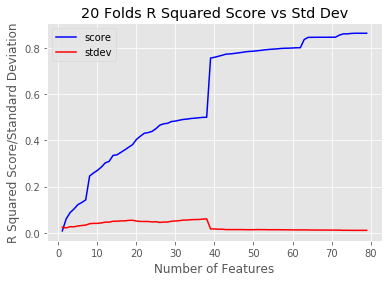

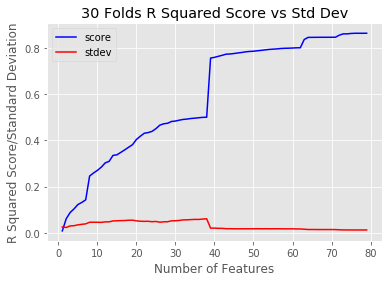

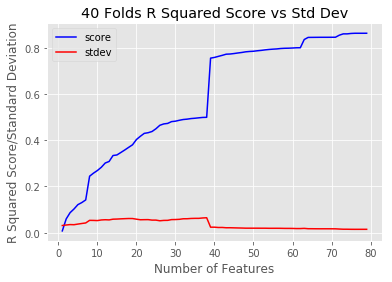

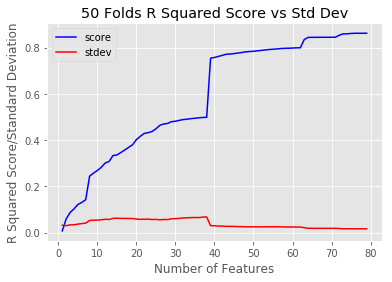

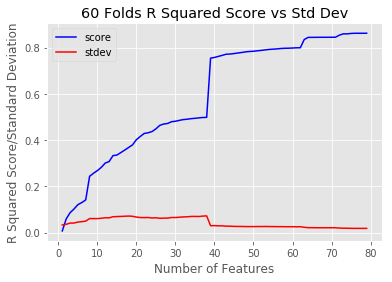

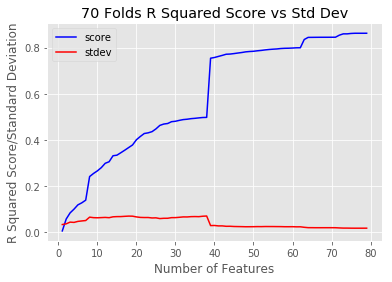

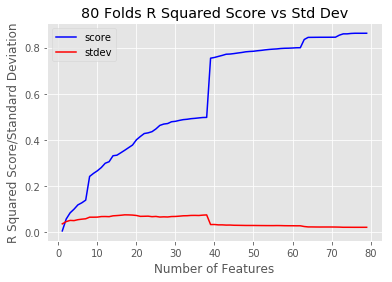

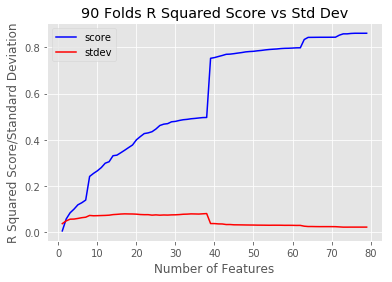

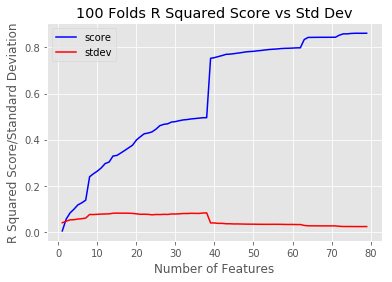

In [71]:
for i in range(10, 101, 10):
    data = cross_results.loc[cross_results['folds'] == i]
    plt.plot(data.features, data.score, color='blue')
    plt.plot(data.features, data.stdev, color='red')
    plt.title("{} Folds R Squared Score vs Std Dev".format(i))
    plt.ylabel("R Squared Score/Standard Deviation")
    plt.xlabel("Number of Features")
    plt.legend()
    plt.show()

In [72]:
highest_score = (0, 0)
for i in range(79):
    cnt = i + 1
    # Just the rows with the same number of features
    data = cross_results.loc[cross_results['features'] == cnt]
    if (np.mean(data.score) > highest_score[0]):
        highest_score = (np.mean(data.score), cnt)

print(highest_score)

(0.8621941219343027, 79)


Next we'll do the same process but without the zipcodes to see how that effects the outcome. We'll be looking to see if the the r squared score and variability don't change too much. If there isn't much of a difference or the scores without the zipcodes are actually better, we'll know that we were overfitting using all the zipcodes and we'll drop them moving forward.

In [73]:
data2, best2 = multiple_cross_validations(X.columns[:11])
cross_results2 = pd.DataFrame(data=data2, columns=data2[0])
cross_results2.drop([0], inplace=True)
cross_results2.head(3)
cross_results2.folds = cross_results2.folds.astype(int)
cross_results2.features = cross_results2.features.astype(int)
cross_results2.score = cross_results2.score.astype(float)
cross_results2.stdev = cross_results2.stdev.astype(float)
cross_results2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 4 columns):
folds       100 non-null int64
features    100 non-null int64
score       100 non-null float64
stdev       100 non-null float64
dtypes: float64(2), int64(2)
memory usage: 3.9 KB


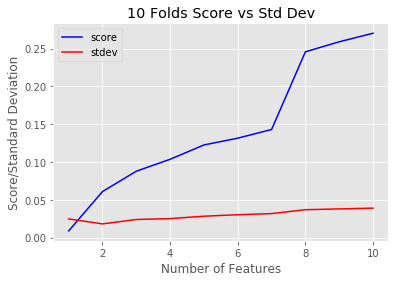

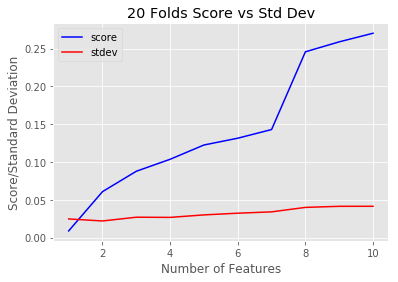

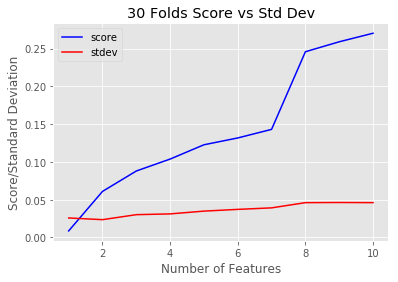

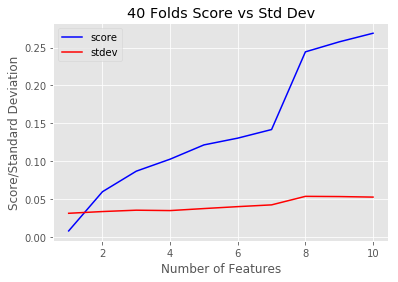

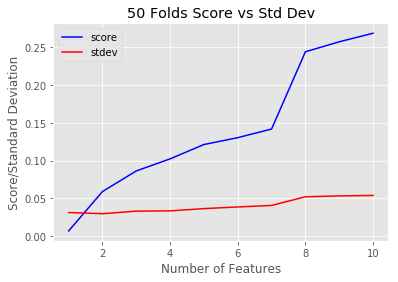

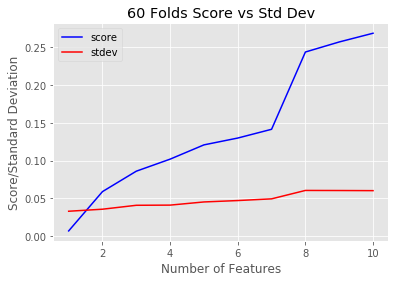

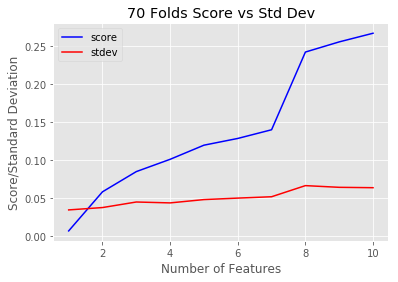

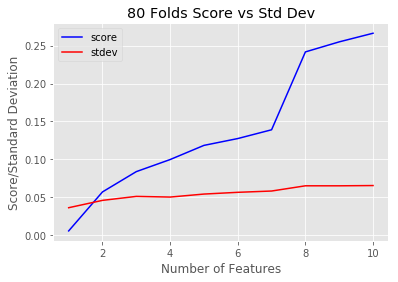

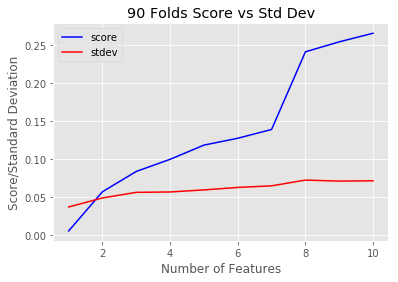

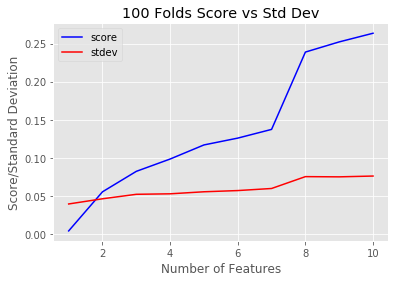

In [74]:
for i in range(10, 101, 10):
    data = cross_results2.loc[cross_results2['folds'] == i]
    plt.plot(data.features, data.score, color='blue')
    plt.plot(data.features, data.stdev, color='red')
    plt.title("{} Folds Score vs Std Dev".format(i))
    plt.ylabel("Score/Standard Deviation")
    plt.xlabel("Number of Features")
    plt.legend()
    plt.show()

In [75]:
print('With Zips:')
print('Mean Score: ', np.mean(cross_results.score), '   Mean Std Dev: ', np.mean(cross_results.stdev))
print('Without Zips:')
print('Mean Score: ', np.mean(cross_results2.score), '   Mean Std Dev: ', np.mean(cross_results2.stdev))

With Zips:
Mean Score:  0.5893908670434521    Mean Std Dev:  0.03883867929266974
Without Zips:
Mean Score:  0.14111391796259476    Mean Std Dev:  0.04501294334439338


As we can see, the r square scores are much higher with the zipcodes and standard deviations are also reduced. The fact that the number of folds in the cross fold validations didn't have much of an effect also goes to show that there wasn't sampling bias that was influencing our results. So we'll keep zipcodes in our dataset and refit the model based on the number of features that best predicted outcome (79). 

In [76]:
# Save the columns we want to include
selector = RFE(linreg, n_features_to_select=highest_score[1])
selector = selector.fit(X, np.ravel(y))
selected_columns = X.columns[selector.support_]
X[selected_columns].head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,lat,sqft_living15,...,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198
1,-0.281743,0.337707,-0.116614,1.005307,-0.087046,0,0.667559,0.247220,1.159259,-0.329620,...,0,0,0,0,0,0,0,0,0,0
2,-1.716211,-1.730377,0.240961,-0.961209,-0.087046,0,-1.750968,-0.657315,1.281074,1.125781,...,0,0,0,0,0,0,0,0,0,0
3,0.736029,1.071372,-0.527126,-0.961209,-0.087046,0,-1.026980,1.400503,-0.283782,-0.993992,...,0,0,0,0,0,0,0,0,0,0
4,-0.281743,0.037330,0.004719,-0.961209,-0.087046,0,0.070139,-0.657315,0.408186,-0.136776,...,0,0,0,0,0,0,0,0,0,0
5,0.736029,2.105414,2.813674,-0.961209,-0.087046,0,2.030036,2.802532,0.691460,2.837190,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Refit model based on the number of features that best predicts outcome
model = sm.OLS(y_log, X[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.096e+04
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:00:58   Log-Likelihood:                -32631.
No. Observations:               18749   AIC:                         6.542e+04
Df Residuals:                   18670   BIC:                         6.604e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0465      0.014     -3.416      0.001      -0.073      -0.020
bathrooms        -0.0073      0.017     -0.426      0.670      -0.041       0.026
sqft_lot         -0.0868      0.015     -5.831      0.000      -0.116      -0.058
floors            0.0417      0.016      2.561      0.010       0.010       0.074
waterfront        0.0262      0.011      2.449      0.014       0.005       0.047
view              0.6622      0.039     16.836      0.000       0.585       0.739
sqft_above        0.2104      0.022      9.441      0.000       0.167       0.254
sqft_basement     0.1930      0.014     13.793      0.000       0.166       0.220
lat               5.7237      0.069     82.555      0.000       5.588       5.860
sqft_living15     0.0525      0.017      3.070      0.002       0.019       0.086
98001            22.9142      0.147    155.679      0.000      22.626      23.203
98002            22.8689      0.163    140.318      0.000      22.549      23.188
98003            22.6061      0.150    150.402      0.000      22.311      22.901
98004            11.3822      0.088    129.012      0.000      11.209      11.555
98005            11.2832      0.114     98.747      0.000      11.059      11.507
98006            13.2622      0.068    194.313      0.000      13.128      13.396
98007            11.1973      0.129     86.552      0.000      10.944      11.451
98008            10.9731      0.092    119.731      0.000      10.794      11.153
98010            22.2722      0.188    118.640      0.000      21.904      22.640
98011             4.9648      0.144     34.524      0.000       4.683       5.247
98014             8.4421      0.147     57.247      0.000       8.153       8.731
98019             5.6429      0.140     40.209      0.000       5.368       5.918
98022            26.9859      0.199    135.579      0.000      26.596      27.376
98023            22.9051      0.142    161.002      0.000      22.626      23.184
98024            13.2938      0.165     80.484      0.000      12.970      13.618
98027            14.6630      0.076    192.419      0.000      14.514      14.812
98028             4.8900      0.131     37.322      0.000       4.633       5.147
98029            13.1460      0.083    158.319      0.000      12.983      13.309
98030            20.4823      0.132    155.378      0.000      20.224      20.741
98031            19.1006      0.119    160.504      0.000      18.867      19.334
98032            20.2153      0.160    126.153      0.000      19.901      20.529
98033             8.3788      0.094     89.441      0.000       8.195       8.562
98034             6.4606      0.102     63.202      0.000       6.260       6.661
98038            20.5732      0.113    182.334      0.000      20.352      20.794
98039            11.2235      0.212     52.955   

<a id="4.4"></a>
### 4. Final Model

In [78]:
# Remove features with a pvalue < 0.05
columns = model.pvalues[model.pvalues <= 0.05]
columns.index
model = sm.OLS(y_log, X[columns.index]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.123e+04
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:00:59   Log-Likelihood:                -32631.
No. Observations:               18749   AIC:                         6.542e+04
Df Residuals:                   18671   BIC:                         6.603e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0474      0.013     -3.521      0.000      -0.074      -0.021
sqft_lot         -0.0858      0.015     -5.839      0.000      -0.115      -0.057
floors            0.0398      0.016      2.542      0.011       0.009       0.070
waterfront        0.0262      0.011      2.453      0.014       0.005       0.047
view              0.6625      0.039     16.845      0.000       0.585       0.740
sqft_above        0.2072      0.021      9.856      0.000       0.166       0.248
sqft_basement     0.1905      0.013     15.000      0.000       0.166       0.215
lat               5.7239      0.069     82.564      0.000       5.588       5.860
sqft_living15     0.0520      0.017      3.047      0.002       0.019       0.085
98001            22.9140      0.147    155.682      0.000      22.626      23.203
98002            22.8692      0.163    140.325      0.000      22.550      23.189
98003            22.6054      0.150    150.409      0.000      22.311      22.900
98004            11.3823      0.088    129.016      0.000      11.209      11.555
98005            11.2822      0.114     98.763      0.000      11.058      11.506
98006            13.2622      0.068    194.317      0.000      13.128      13.396
98007            11.1972      0.129     86.554      0.000      10.944      11.451
98008            10.9726      0.092    119.740      0.000      10.793      11.152
98010            22.2720      0.188    118.642      0.000      21.904      22.640
98011             4.9634      0.144     34.524      0.000       4.682       5.245
98014             8.4401      0.147     57.263      0.000       8.151       8.729
98019             5.6412      0.140     40.214      0.000       5.366       5.916
98022            26.9853      0.199    135.583      0.000      26.595      27.375
98023            22.9048      0.142    161.005      0.000      22.626      23.184
98024            13.2922      0.165     80.497      0.000      12.969      13.616
98027            14.6623      0.076    192.463      0.000      14.513      14.812
98028             4.8892      0.131     37.320      0.000       4.632       5.146
98029            13.1445      0.083    158.450      0.000      12.982      13.307
98030            20.4817      0.132    155.386      0.000      20.223      20.740
98031            19.0995      0.119    160.539      0.000      18.866      19.333
98032            20.2170      0.160    126.206      0.000      19.903      20.531
98033             8.3782      0.094     89.446      0.000       8.195       8.562
98034             6.4592      0.102     63.225      0.000       6.259       6.659
98038            20.5717      0.113    182.422      0.000      20.351      20.793
98039            11.2228      0.212     52.955      0.000      10.807      11.638
98040            13.3805      0.091    146.850   

Since the r-squared doesn't change, we know removing the columns with a low p-value doesn't effect our model

<a id="5"></a>
## Interpretation

Our final model was highly predictive with an r-squared of  **0.989**, compared to **0.749** before feature selection and **0.799** before we log transformed our dependent variable. So, **98.9%** of of the variations are explained by our model. Our final model included 78 variables, 70 of which were zip code one hot encoded columns. Most of the numeric variables in our dataset were nearly as predicitive of price as the zip codes. In the end the biggest factors were variables that had to do with location and size. 

### Latitude
The `lat` coefficient is **5.7239**. Meaning that with all other predictors held constant, a one standard deviation (**0.13873483127904035**) change in `lat` causes a **30,509.64%** change in price. For perspectie, that's about a **3182%** change for every mile. Since latitude gets bigger as it moves from the equator to the poles, `price` increases as we move North. This was was a little surprising to me, so I did some research on Seattle. It seems that the industrial parts are directly below downtown. So it would make sense that the more popular areas to live would be the suburbs to the North. Roughly **89.2%** of houses sold in this dataset were north of the industrial district despite the fact that the industrial district is relatively far north in terms of the county as a whole. So it would make sense that the more popular areas to live would be the suburbs to the North. 

### Square Feet Above
Other than `lat` and the zip codes, the two predictors dealing with the size of the house had the largest impact on the `price` of the house. The `sqft_above` coefficient was **0.2072**, which means that for every 100 feet added `sqft_above`, `price` increases **2.38%**. We expected this to be the case where as a house gets bigger, so does the `price`. `sqft_basement` has a pretty similar effect, albeit slightly less.

### View
The `view` coefficient is **0.6625**. Meaning that with all other predictors held constant, a one standard deviation (0.29519038492) change in `view` causes a 93.96% change in price. Since `view` is binary, it's only helpful to calculate the difference between not having been viewed versus being viewed is. 

| View | Change in Price|
|------|----------------|
| Yes  | 287.61%        |
| No   | -30.7%         |

So you should always show the house before a sale because it has dramatic effect on the price you're able to sell it for and not showing it can actually hurt you. 

### Other Notable Observations
The interesting thing is thtat none of the zip codes in our model had a negative impact on the price, just a wide variance in positive impacts. The highest impact zip code was `zipcode_98022` with a coefficient of **26.9853** and the lowest was `zipcode_98028` with a coefficient of **4.8892**. With the largest cofficient for a non-zip code independent variable being `lat` (**5.7239**) and all others being below **1**, we can conclude that location really is king in real estate. 

# Conclusion



# Future Work

1. Expand the time covered
To make the results more reliable, we need to expand the timeframe of the data in this project. Currently, we only have a short period of time accounted for and none of it was in a bear market. 

2. Adjust our definitions
Currently we are only calculating if the price of the stock increased, decreased or stayed the same. We should adjust our definitions to be in relation to the overal performance of the S&P 500. There are plenty of low cost ETF's and mutual funds that follow the S&P 500. So, for our model to be actionable, we need to make sure that the stocks we are recommending as growth companies will outperform easier, less risky options.

3. Broaden our focus
We can expand the reach of our project by including stocks taht aren't in the S&P 500. Potentially finding a lot more high growth companies. 

---

# Recap
## Scrub

### Dealing with Datatypes
- Waterfront and zipcode were cast to categorical variables
- Sqft_basement, view and yr_renovated were cast to ints
- Turned date into a numermerical column so that we can run statistics on it.

### Dealing with Null Values
- Chose to drop all rows that had null values in the view and sqft_basement columns
- For yr_renovated, we replaced all null and 0 values with the year that the house was built. 

### Check for Multicolinearity

**Columns with high correlation:**
- sqft_living, sqft_above and grade
- bathrooms, sqft_living\*
- sqft_lot and sqft_lot15
- yr_built and year_renovated

**DROPPED:**
- id
- grade
- sqft_living
- sqft_lot15
- yr_renovated

### Normalized Data

- Log transformed certain independent variables and the dependent variable
- Standardized numerical columns to reduce the influence of units or scale

## Model

### Dimensionality Reduction
- Used K-Fold Cross Validation using several values for k to insure no overfitting. 
- Calculated the r squared scores and standard deviation of the r squared scores for each trial. 
- Determined that the results were consistent no matter how the data was divided into train/test sets. 
- Determined 79 features was the most perdictive model with the least variance

### Final Model
- Using 79 features, we built an OLS regression model for Price



